<a href="https://colab.research.google.com/github/jonathashaniel/ML-for-stock-market/blob/master/ML_for_stock_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
from datetime import timedelta
import numpy as np

def test(p,n):
    if p>n: return 1
    else: return -1

def Obter_dados(tickers,lookback_lenght):
    dados = pd.DataFrame
    start=dt.datetime.now()-dt.timedelta(days=lookback_lenght*2) # *2 por causa dos dias nao letivos
    for ticker in tickers:
        stock = web.DataReader(ticker, 'yahoo',start)
        stock['Tickle'] = [ticker for _ in range (len(stock) )]
        stock.reset_index(inplace = True)
        stock.set_index(['Tickle','Date'], inplace = True)
        if dados.empty:
            dados = stock
        else:
            dados = pd.concat([dados, stock])
    return dados

def MMA(dados,window=6):
    mma=dados.rolling(window).mean()
    return mma

def Variation(dados,days):
    var = 100* (dados.shift(-days)/dados - 1)
    return var
    
def RSI(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return pd.Series(rsi)

def ADX(df, n, n_ADX):
    """Calculate the Average Directional Movement Index for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :param n_ADX: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'High'] - df.loc[i, 'High']
        DoMove = df.loc[i, 'Low'] - df.loc[i + 1, 'Low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < df.index[-1]:
        TR = max(df.loc[i + 1, 'High'], df.loc[i, 'Close']) - min(df.loc[i + 1, 'Low'], df.loc[i, 'Close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, min_periods=n_ADX).mean(),
                    name='ADX_' + str(n) + '_' + str(n_ADX))
    

        
    state=pd.Series(list(map(test,PosDI,NegDI)))
    return ADX, state

def Stochastic(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
    state = pd.Series(list(map(test,SOd,SOd.shift(2))))
    
    return SOd, state

def TRIX(df, n):
    """Calculate TRIX for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    EX1 = df['Close'].ewm(span=n, min_periods=n).mean()
    EX2 = EX1.ewm(span=n, min_periods=n).mean()
    EX3 = EX2.ewm(span=n, min_periods=n).mean()
    i = 0
    ROC_l = [np.nan]
    while i + 1 <= df.index[-1]:
        ROC = (EX3[i + 1] - EX3[i]) / EX3[i]
        ROC_l.append(ROC)
        i = i + 1
    Trix = pd.Series(ROC_l, name='Trix_' + str(n))
    state = pd.Series(list(map(test,Trix,Trix.shift(2))))

    return  Trix, state

def HILO(dados, n=4):
    hilo = []
    high = MMA(dados['High'],n).values
    low = MMA(dados['Low'],n).values
    close = dados['Close'].values
    #print(len(high), len(low), len(close))
    for i in range(len(high)):
        if close[i] >= high[i]:
            hilo.append(1)
        elif close[i] <= low[i]:
            hilo.append(-1)
        else:
            if i > 0:
                hilo.append(hilo [i-1])
            else:
                hilo.append(np.NaN)
    return pd.Series(hilo)

In [0]:
lookback_lenght=900
####escolhendo as ações
tickers50=['VALE3.SA', 'PETR4.SA', 'BOVA11.SA','ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA', 'B3SA3.SA',
           'MGLU3.SA', 'ITUB3.SA', 'ITSA4.SA', 'USIM5.SA', 'BRFS3.SA', 'PETR3.SA', 'KROT3.SA', 'EMBR3.SA',
           'GGBR4.SA', 'VIVT4.SA', 'GOAU4.SA', 'JBSS3.SA', 'RADL3.SA', 'CSNA3.SA', 'RAIL3.SA', 
           'CIEL3.SA', 'ESTC3.SA', 'LREN3.SA', 'CCRO3.SA', 'BRDT3.SA', 'UGPA3.SA', 'BBSE3.SA', 'BRKM5.SA', 
           'LAME4.SA', 'CMIG4.SA', 'CSAN3.SA',  'SUZB3.SA', 'QUAL3.SA', 'SANB11.SA', 'BRML3.SA', 'ELET3.SA', 
           'PCAR4.SA', 'EQTL3.SA', 'BRAP4.SA', 'SMLS3.SA', 'HYPE3.SA', 'FLRY3.SA', 'MULT3.SA', 'RENT3.SA', 'MRVE3.SA','BIDI4.SA']
tickers10=['VALE3.SA', 'PETR4.SA', 'PETR3.SA', 'BBDC4.SA', 'BBAS3.SA', 
           'EMBR3.SA', 'ELET3.SA', 'ELET6.SA', 'ITSA4.SA', 'ITUB3.SA','CMIG4.SA','CMIG3.SA']

tickersx=tickers50

#obtendo todos os dados
dados=Obter_dados(tickersx,lookback_lenght)
dados.to_pickle('dados.pickle')


In [5]:
dados = pd.read_pickle('dados.pickle')
#print(dados.loc['PETR4.SA']['Close'].head())
Tickles = dados.index.levels[0]
Columns = dados.columns

n_mma = 26

#criando os indicadores
for tick in Tickles:
    #state means: -1 = SELL; 1= BUY
    dados.loc[tick,'mma']=MMA(dados.loc[tick]['Close'], n_mma).values
    dados.loc[tick,'mma_state']=pd.Series(list(map(test,dados.loc[tick,'Close'],dados.loc[tick,'mma']))).values
    dados.loc[tick,'back_var']=Variation(dados.loc[tick]['Close'], -1).values
    dados.loc[tick,'var_1']=Variation(dados.loc[tick]['Close'], 1).values
    dados.loc[tick,'var_4']=Variation(dados.loc[tick]['Close'], 4).values
    dados.loc[tick,'Acumuled_var_60']=Variation(dados.loc[tick]['Close'], -60).values
    dados.loc[tick,'var_volume']=Variation(dados.loc[tick]['Volume'], 3).values
    dados.loc[tick,'rsi']=RSI(dados.loc[tick]['Close'], 14).values
    dados.loc[tick,'ADX']=ADX(dados.loc[tick].reset_index(level=['Date']), 9,9)[0].values
    dados.loc[tick,'ADX_state']=ADX(dados.loc[tick].reset_index(level=['Date']), 9,9)[1].values
    dados.loc[tick,'Stochastic']=Stochastic(dados.loc[tick].reset_index(level=['Date']), 10)[0].values
    dados.loc[tick,'Stochastic_state']=Stochastic(dados.loc[tick].reset_index(level=['Date']), 10)[1].values
    dados.loc[tick,'trix']=TRIX(dados.loc[tick].reset_index(level=['Date']), 9)[0].values
    dados.loc[tick,'trix_state']=TRIX(dados.loc[tick].reset_index(level=['Date']), 9)[1].values
    dados.loc[tick,'hilo_state']=HILO(dados.loc[tick].reset_index(level=['Date']), 4).values

dados.to_pickle('dados.pickle')
#print(dados.loc['MGLU3.SA'].tail())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
dados = pd.read_pickle('dados.pickle')
#print(dados.loc['PETR4.SA'].tail())
Tickles = dados.index.levels[0]
Columns = dados.columns

# limpeza e tratamento dos dados para SMV e Neural network
dados.reset_index(level=['Date', 'Tickle'], inplace = True)
#removing prices data (because it is specific to a tickle), non-numeric data
dados.drop(['Close', 'Date', 'Tickle', 'High', 'Low', 'Open', 'Volume', 'Adj Close',
           'mma'],axis = 1, inplace = True) #maybe retain tickle someway
dados.replace([np.inf, -np.inf], np.nan, inplace = True)
dados.dropna(inplace = True)

profit=3
#create label
def create_label(x, y = profit):
    if x > y:
        return 1
    else:
        return 0
    
#using 'var_4' to make label, if there is a variation bigger than 2% in 4 days its positive
#otherwise it is null
dados['Label'] = list(map(create_label,dados['var_4']))

#deleting var_1 and 4 because they "see the future"
dados.drop(['var_1', 'var_4'],axis = 1, inplace = True)

print(dados.tail(10))

       mma_state  back_var  Acumuled_var_60  var_volume        rsi       ADX  \
55073       -1.0 -0.795623       -14.346097   -8.489565  48.399706  0.203150   
55074       -1.0  1.848568        -4.786030   32.039574  44.493139  0.255126   
55075       -1.0  1.256415        -3.820517    8.567931  42.040253  0.296707   
55076       -1.0  0.931679        -2.976185  -32.817936  40.283146  0.366223   
55077       -1.0  1.151829         2.670158    1.037464  38.182605  0.305345   
55078       -1.0 -4.666830        -1.547290   64.862834  50.093394  0.256643   
55079       -1.0  0.000000        -2.645374  152.704258  50.093394  0.235519   
55080        1.0 -1.305416        -5.295561  140.245294  53.065890  0.276364   
55081        1.0 -2.050669        -5.910738   43.013449  57.443701  0.348796   
55082        1.0 -3.604649        -8.953485  -54.212204  64.032096  0.422692   

       ADX_state  Stochastic  Stochastic_state      trix  trix_state  \
55073       -1.0    0.559570               1.0 

In [7]:
#Suport Vector Machine, naive baynes, linear model, neighbors  with SKlearn
from sklearn import svm, preprocessing , model_selection
import sklearn.naive_bayes as nb
import sklearn.neighbors as ni
import sklearn.linear_model as lm

X = np.array(dados.drop(['Label'],1))
X = preprocessing.scale(X)
#X = preprocessing.robust_scale(X)

y=np.array(dados['Label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25,shuffle=True)


#################chose your classifier##############################

#clf = svm.SVC(kernel='linear') #score= 0.7577 (scale)
#clf = svm.SVC(kernel='rbf')  #score= 0.7548(robust_scale)
#clf = svm.SVC(kernel='sigmoid')  #score= 0.6357 (robust_scale)
#clf =  nb.GaussianNB()  #score= 0.7270 (robust_scale)
#clf =  ni.KNeighborsClassifier()  #score= 0.7163 (robust_scale)
clf =  lm.SGDClassifier(max_iter=10000, tol=1e-10)  #score= 0.55 to 0.75

clf.fit(X_train,y_train)

print(clf.score(X_test,y_test))


0.7566739949748744


Instructions for updating:
Colocations handled automatically by placer.
loss: [0.761778] Train accuracy 0.24647316 Test accuracy 0.24332601


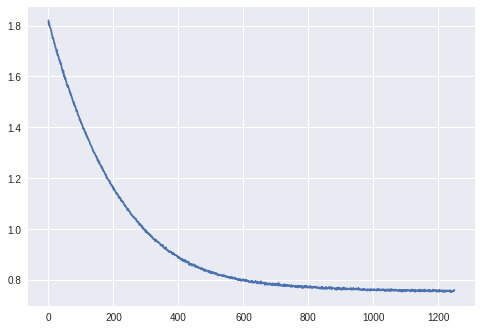

In [8]:
## using tensorflow linear SVM
import tensorflow as tf

sess = tf.Session()
#print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
#Create the placeholder and Variable

batch_size = X_train.shape[0] # the same loss is reached with with only 10% batch size
x_data = tf.placeholder(shape=[None, X_train.shape[1]], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
A = tf.Variable(tf.random_normal(shape=[X_train.shape[1],1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

#Declare the model output.
model_output = tf.subtract(tf.matmul(x_data, A), b)

#Declare the necessary components for the maximum margin loss.
l2_norm = tf.reduce_sum(tf.square(A))
alpha = tf.constant([0.1])
classification_term = tf.reduce_mean(tf.maximum(0., tf.subtract(1.,tf.multiply(model_output, y_target))))
loss = tf.add(classification_term, tf.multiply(alpha, l2_norm))

#Declare the prediction and accuracy functions.
prediction = tf.sign(model_output)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, y_target),tf.float32))

#Declare the optimizer.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.initializers.global_variables()
sess.run(init)

#Train.
loss_vec = []
train_accuracy = []
test_accuracy = []
n_epoch = 1250
for i in range(n_epoch):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    X = X_train[rand_index]
    Y = np.transpose([y_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: X, y_target: Y})
    temp_loss = sess.run(loss, feed_dict={x_data: X, y_target: Y})
    loss_vec.append(temp_loss)
    train_acc_temp = sess.run(accuracy, feed_dict={x_data: X_train, y_target: np.transpose([y_train])})
    train_accuracy.append(train_acc_temp)
    test_acc_temp = sess.run(accuracy, feed_dict={x_data: X_test, y_target: np.transpose([y_test])})
    test_accuracy.append(test_acc_temp)
    
    #print('loss:',temp_loss, 'Train accuracy',train_acc_temp,'Test accuracy', test_acc_temp)
plt.plot(loss_vec)
print('loss:',temp_loss, 'Train accuracy',train_acc_temp,'Test accuracy', test_acc_temp)

loss: -8023.455 batch accuracy 0.2399


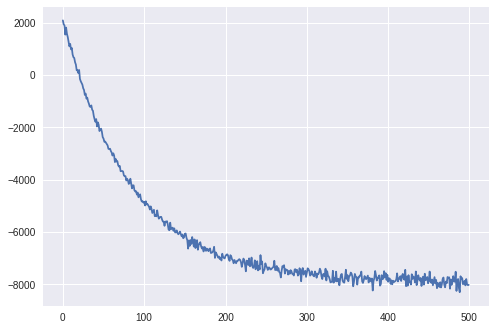

In [15]:
## using tensorflow Non-Linear SVM
'''https://medium.com/cs-note/tensorflow-ch4-support-vector-machines-c9ad18878c76'''
sess = tf.Session()

batch_size = 8000#X_train.shape[0] 
x_data = tf.placeholder(shape=[None, X_train.shape[1]], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, X_train.shape[1]], dtype=tf.float32)
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))


#Gaussian kernel
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, tf.multiply(2., tf.matmul(x_data,tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

#compute loss
model_output = tf.matmul(b, my_kernel)
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross,y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

#Create the prediction function.
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data,
tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b),pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction),tf.squeeze(y_target)), tf.float32))

#Declare the optimizer function.
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)
init = tf.initializers.global_variables()
sess.run(init)
#Train.

loss_vec = []
batch_accuracy = []
n_epoch = 500
for i in range(n_epoch):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    X = X_train[rand_index]
    Y = np.transpose([y_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: X, y_target:Y})
    temp_loss = sess.run(loss, feed_dict={x_data: X, y_target: Y})
    loss_vec.append(temp_loss)
    acc_temp = sess.run(accuracy, feed_dict={x_data: X,y_target: Y,prediction_grid:X})
    batch_accuracy.append(acc_temp)
    
    
    #print('loss:',temp_loss,  'batch accuracy', acc_temp)
plt.plot(batch_accuracy)
print('loss:',temp_loss,  'batch accuracy', acc_temp)

In [0]:
## add neural network goal score = 0.75

